In [42]:
#scaling constants
B_b   = 1e1
b_B   = 1/B_b
G_1   = 1e9
one_G = 1/G_1
G_K   = 1e6
K_G   = 1/G_K
G_M   = 1e3
M_G   = 1/G_M
K_1   = 1e3
one_K = 1/K_1
M_1   = 1e6
one_M = 1/M_1
m_1   = 1e-3
one_m = 1/m_1
m_u   = 1e3 
u_m   = 1/m_u
u_1   = 1e-6
one_u = 1/u_1
n_1   = 1e-9
one_n = 1/n_1
n_m   = 1e-6
m_n   = 1/n_m

sz1K  = 1024
sz1M  = sz1K*sz1K
sz1G  = sz1M*sz1K


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
import re
from datetime import datetime

sns.set(style="darkgrid")

# Compute statistical moments: mean, std, skewness, kurtosis
def compute_moments(series):
    values = series.dropna()
    return {
        'count': len(values),
        'mean': values.mean(),
        'std': values.std(),
        'skew': skew(values),
        'kurtosis': kurtosis(values)
    }

# Load the log file into a list of lines
def load_log_file(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    return [line.strip() for line in lines if line.strip()]


In [44]:
# Replace this with the actual path to your log file
log_path = "emu_log.txt"

# Load and inspect
lines = load_log_file(log_path)
print(f"Loaded {len(lines)} lines from the log.")


Loaded 141581 lines from the log.


In [45]:
timestamps = []
waiting_lines = [line for line in lines if "emulate_stream" in line and "emulate_sender-zmq" not in line]
for line in waiting_lines[0:1]:
    match = re.search(r"\(1\)", line)
    if match:
        # extract timestamp at the beginning of the line
        ts_match = re.match(r"([\d.]+)", line)
        timestamps.append(int(ts_match.group(1)) if ts_match else None)
    else:
        print("No match")
min_uS = min(timestamps)
print(min_uS)

1752791687660620


In [46]:
waiting_lines[0:5]

['1752791687660620 [emulate_stream:] Sending frame size = 56824 frame_num = (1)',
 '1752791687660620 [emulate_stream:] serialize_packet: Serializing frame: size = 56824 timestamp = 1752791687660620 stream_id = 99 frame_num = (1) ...',
 '1752791687660623 [emulate_stream:] Rate Sleeping for: 0.03788266666666667 seconds',
 '1752791687698982 [emulate_stream:] Read Raw clock as: 1752791687.6989794',
 '1752791687698980 [emulate_stream:] Estimated frame rate (Hz): 26.069501290440314 frame_num 1 elpsd_tm_us 38359']

📊 Sender Estimated Frame Rate Statistics:
count: 1000.000
mean: 24.789
std: 0.128
skew: 2.369
kurtosis: 23.946


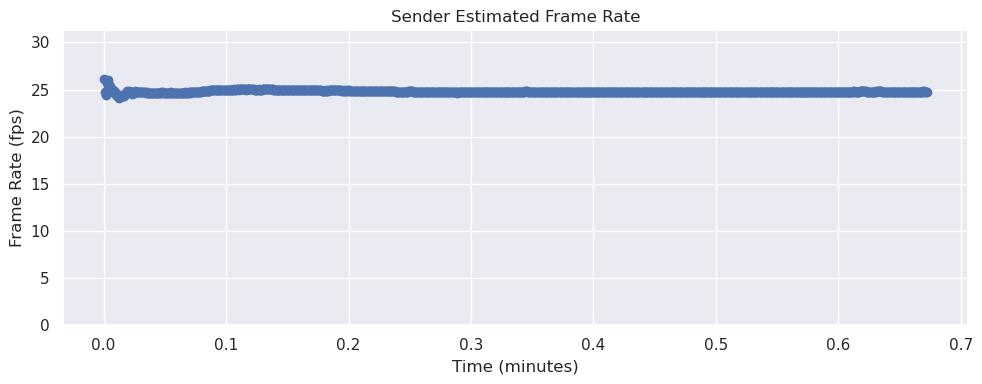

In [47]:
# Extract lines with frame rate information
#frame_rate_lines = [line for line in lines if "Sender estimated frame rate is" in line]
frame_rate_lines = [line for line in lines if "[emulate_stream:] Estimated frame rate (Hz): " in line]

# Parse frame rate values from lines
frame_rates = []
timestamps = []
for line in frame_rate_lines:
    match = re.search(r"\[emulate_stream:\] Estimated frame rate \(Hz\): ([\d.]+)", line)
    if match:
        value = float(match.group(1))
        frame_rates.append(value)
        # Optional: extract timestamp if available at the beginning of the line
        ts_match = re.match(r"([\d.]+)", line)
        timestamps.append(ts_match.group(1) if ts_match else None)
    else:
        print("No match")

# Create a DataFrame
frame_rate_df = pd.DataFrame({
#    'timestamp': pd.to_datetime(timestamps, errors='coerce'),
    'timestamp': timestamps,
    'frame_rate': frame_rates
})

# Display statistics
frame_rate_stats = compute_moments(frame_rate_df['frame_rate'])

# Convert microseconds to zero based minutes
frame_rate_df['minutes'] = ((frame_rate_df['timestamp'].astype(float)-min_uS) * u_1)/60  #minutes

print("📊 Sender Estimated Frame Rate Statistics:")
for k, v in frame_rate_stats.items():
    print(f"{k}: {v:.3f}")
# Plot
plt.figure(figsize=(10, 4))
plt.plot(frame_rate_df['minutes'], frame_rate_df['frame_rate'], marker='o', linestyle='-')

plt.title('Sender Estimated Frame Rate')
plt.xlabel('Time (minutes)')
plt.ylabel('Frame Rate (fps)')
plt.ylim(0, max(frame_rate_df['frame_rate']) * 1.2)  # Give headroom
plt.grid(True)

plt.tight_layout()
plt.show()


In [48]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Set Seaborn style
# sns.set(style="whitegrid", context="talk")

# # Create the Seaborn line plot
# plt.figure(figsize=(10, 4))
# sns.lineplot(
#     data=frame_rate_df,
#     x='minutes',
#     y='frame_rate',
#     marker='o',
#     linewidth=2,
#     color='royalblue'
# )

# # Customize labels and title
# plt.title('Sender Estimated Frame Rate', fontsize=16)
# plt.xlabel('Time (minutes)', fontsize=14)
# plt.ylabel('Frame Rate (fps)', fontsize=14)
# plt.ylim(0, frame_rate_df['frame_rate'].max() * 1.2)
# plt.tight_layout()
# plt.show()


In [49]:
frame_rate_df['timestamp'].astype(float).head(5)

0    1.752792e+15
1    1.752792e+15
2    1.752792e+15
3    1.752792e+15
4    1.752792e+15
Name: timestamp, dtype: float64

📊 Sender Bit Rate Statistics (bps):
count: 1000.000
mean: 15.120
std: 1.585
skew: 0.627
kurtosis: 0.528


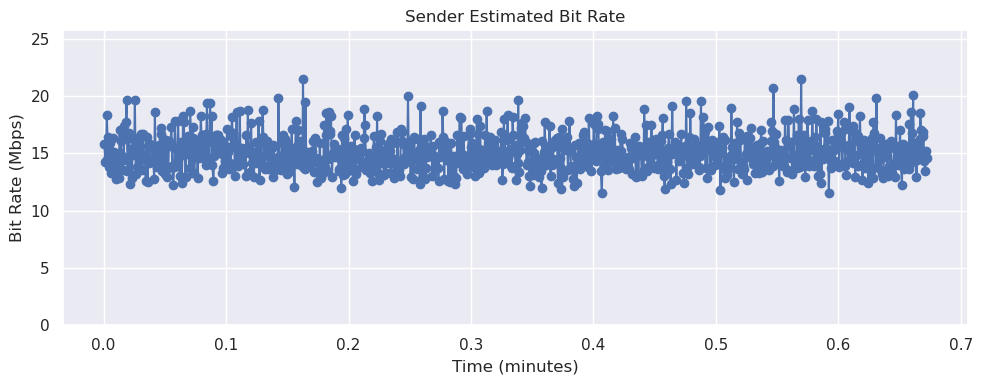

In [50]:
# Extract lines with bit rate information
bit_rate_lines = [line for line in lines if "[emulate_stream:] Estimated bit rate (bps):" in line]

# Parse bit rate values and timestamps
bit_rates = []
timestamps = []
for line in bit_rate_lines:
    match = re.search(r"\[emulate_stream:\] Estimated bit rate \(bps\): ([\d.]+)", line)
    if match:
        value = float(match.group(1))
        bit_rates.append(value*one_M)
        ts_match = re.match(r"([\d.]+)", line)
        timestamps.append(ts_match.group(1) if ts_match else None)
    else:
        print("No match in bit rate line:", line)

# Create a DataFrame
bit_rate_df = pd.DataFrame({
    'timestamp': timestamps,
    'bit_rate': bit_rates
})

# Convert microseconds to zero based minutes
bit_rate_df['minutes'] = ((bit_rate_df['timestamp'].astype(float)-min_uS) * u_1)/60  #minutes

# Compute statistics
bit_rate_stats = compute_moments(bit_rate_df['bit_rate'])

# Display statistics
print("📊 Sender Bit Rate Statistics (bps):")

for k, v in bit_rate_stats.items():
    print(f"{k}: {v:.3f}")

# Plot
plt.figure(figsize=(10, 4))
plt.plot(bit_rate_df['minutes'], bit_rate_df['bit_rate'], marker='o', linestyle='-')
plt.title('Sender Estimated Bit Rate')
plt.xlabel('Time (minutes)')
plt.ylabel('Bit Rate (Mbps)')
plt.ylim(0, max(bit_rate_df['bit_rate']) * 1.2)
plt.grid(True)
plt.tight_layout()
plt.show()


In [51]:
bit_rate_df.head(5)

,timestamp,bit_rate,minutes
0,1752791687698981,15.838378,0.000639
1,1752791687741284,14.269633,0.001344
2,1752791687783334,14.335319,0.002045
3,1752791687816263,18.332926,0.002594
4,1752791687853040,16.409284,0.003207


📊 Sender Frame Size Statistics (Mbps):
count: 1000.000
mean: 60.158
std: 6.102
skew: -0.025
kurtosis: -0.143


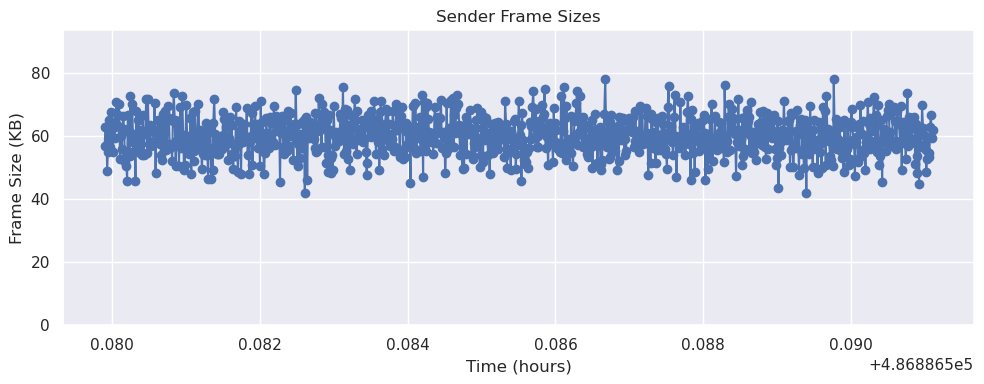

In [52]:
# Extract lines with bit rate information
sent_frame_lines = [line for line in lines if "[emulate_stream:] Sending frame" in line]

# Parse bit rate values and timestamps
frame_sizes = []
timestamps = []
for line in sent_frame_lines:
    match = re.search(r"\[emulate_stream:\] Sending frame size = ([\d.]+)", line)
    if match:
        value = float(match.group(1))
        frame_sizes.append(value*one_K)
        ts_match = re.match(r"([\d.]+)", line)
        timestamps.append(ts_match.group(1) if ts_match else None)
    else:
        print("No match in frame size line:", line)

# Create a DataFrame
frame_size_df = pd.DataFrame({
    'timestamp': timestamps,
    'frame_size': frame_sizes
})

# Convert microseconds to hours
frame_size_df['hours'] = frame_size_df['timestamp'].astype(float) / 3_600_000_000
# Convert microseconds to zero based minutes
frame_rate_df['minutes'] = ((frame_rate_df['timestamp'].astype(float)-min_uS) * u_1)/60  #minutes

# Compute statistics
frame_size_stats = compute_moments(frame_size_df['frame_size'])

# Display statistics
print("📊 Sender Frame Size Statistics (Mbps):")

for k, v in frame_size_stats.items():
    print(f"{k}: {v:.3f}")

# Plot
plt.figure(figsize=(10, 4))
plt.plot(frame_size_df['hours'], frame_size_df['frame_size'], marker='o', linestyle='-')
plt.title('Sender Frame Sizes')
plt.xlabel('Time (hours)')
plt.ylabel('Frame Size (KB)')
plt.ylim(0, max(frame_size_df['frame_size']) * 1.2)
plt.grid(True)
plt.tight_layout()
plt.show()


In [53]:
sent_frame_lines = [line for line in lines if "[emulate_stream:] Sending frame" in line]
sent_frame_lines[:5]

['1752791687660620 [emulate_stream:] Sending frame size = 56824 frame_num = (1)',
 '1752791687698979 [emulate_stream:] Sending frame size = 63071 frame_num = (2)',
 '1752791687741282 [emulate_stream:] Sending frame size = 62782 frame_num = (3)',
 '1752791687783332 [emulate_stream:] Sending frame size = 49092 frame_num = (4)',
 '1752791687816261 [emulate_stream:] Sending frame size = 54847 frame_num = (5)']

In [54]:
frame_size_df.head(5)

,timestamp,frame_size,hours
0,1752791687660620,56.824,486886.579906
1,1752791687698979,63.071,486886.579916
2,1752791687741282,62.782,486886.579928
3,1752791687783332,49.092,486886.579940
4,1752791687816261,54.847,486886.579949


In [55]:
recd_lines = [line for line in lines if "cpu_emu" in line and "6004" in line and "done" in line]
recd_lines[:5]

['1752791696004770 [cpu_emu 6001]:  done (208)',
 '1752791688460046 [cpu_emu 6002]:  done (18)',
 '1752791687838613 [cpu_emu 6004]:  done (1)',
 '1752791687873356 [cpu_emu 6004]:  done (2)',
 '1752791687900456 [cpu_emu 6004]:  done (3)']

In [56]:
#determine emulation port range
#port_lines = [line for line in lines if "Connecting to receiver tcp" in line]
cmpnt_ids = []
port_lines = [line for line in lines if "Subscribing to" in line]
#port_lines
for line in port_lines:
    match = re.search(r"cpu_emu ([\d.]+)", line)
    if match:
        value = float(match.group(1))
        cmpnt_ids.append(int(value))
    else:
        print("No match in port line:", line)
cmpnt_ids


[6000, 6001, 6002, 6003, 6004, 6005, 6006]

In [57]:
port_lines[:5]

['[cpu_emu 6000]:  Subscribing to 129.57.177.8:6000',
 '[cpu_emu 6001]:  Subscribing to 129.57.177.8:6001',
 '[cpu_emu 6002]:  Subscribing to 129.57.177.2:6002',
 '[cpu_emu 6003]:  Subscribing to 129.57.177.3:6003',
 '[cpu_emu 6004]:  Subscribing to 129.57.177.4:6004']


🔧 Component 0:
Component 0 Statistics (Hz):
count: 900.000
mean: 24.811
std: 0.095
skew: 1.306
kurtosis: 0.400


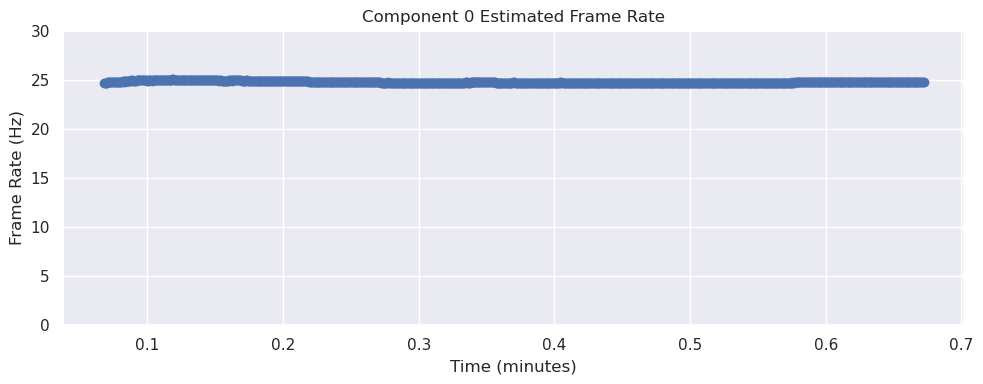


🔧 Component 1:
Component 1 Statistics (Hz):
count: 827.000
mean: 22.719
std: 0.113
skew: 1.960
kurtosis: 4.012


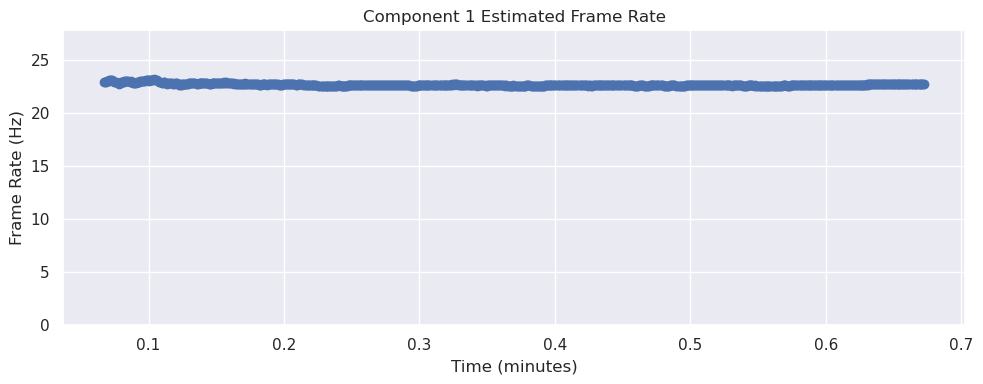


🔧 Component 2:
Component 2 Statistics (Hz):
count: 786.000
mean: 21.676
std: 0.128
skew: 1.186
kurtosis: 1.080


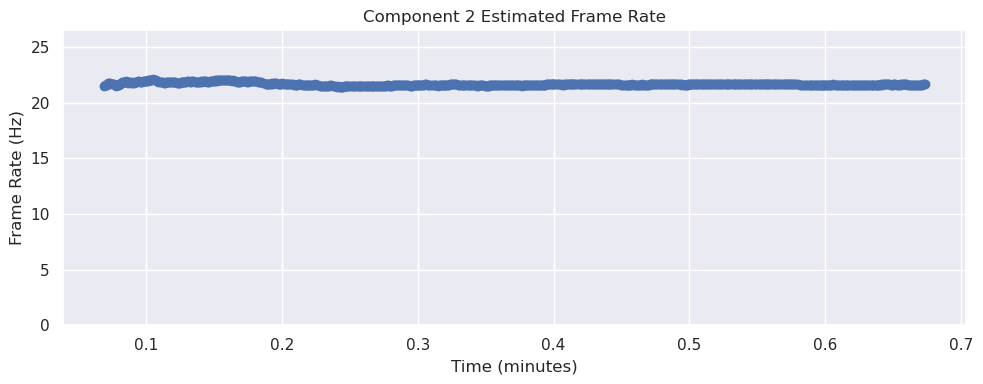


🔧 Component 3:
Component 3 Statistics (Hz):
count: 774.000
mean: 21.298
std: 0.184
skew: 1.063
kurtosis: 1.100


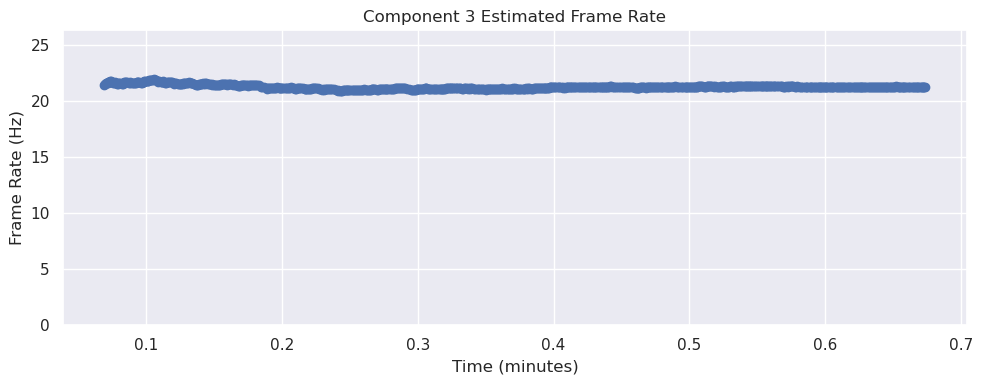


🔧 Component 4:
Component 4 Statistics (Hz):
count: 762.000
mean: 20.945
std: 0.131
skew: 0.116
kurtosis: 0.390


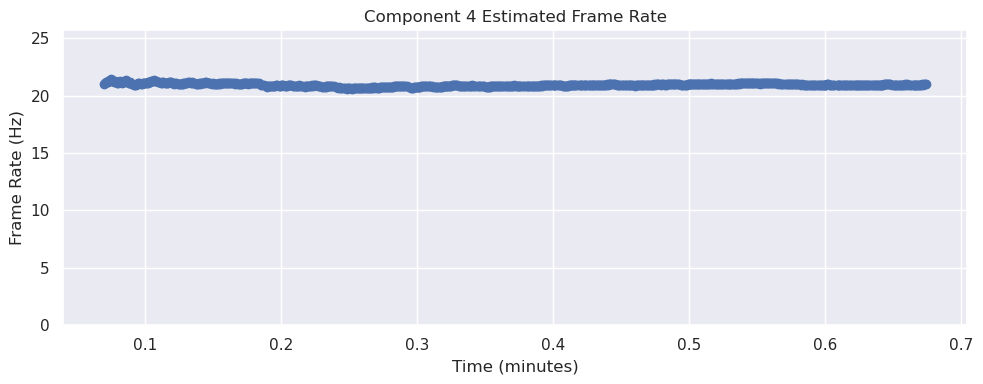


🔧 Component 5:
Component 5 Statistics (Hz):
count: 758.000
mean: 20.795
std: 0.141
skew: -0.328
kurtosis: 0.104


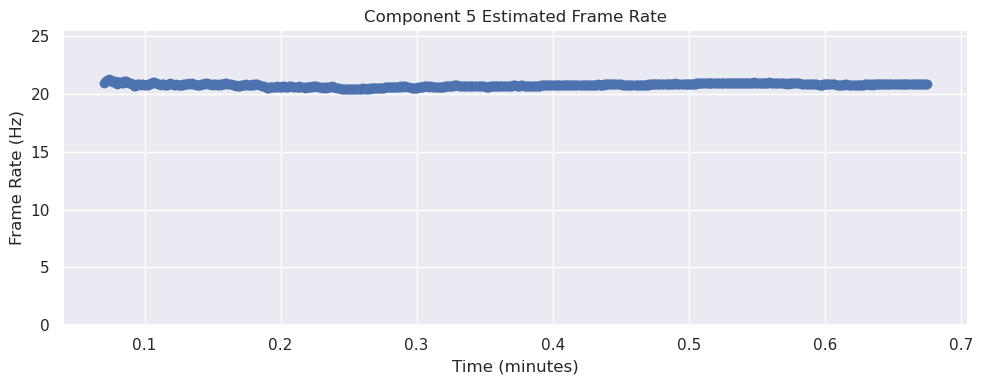


🔧 Component 6:
Component 6 Statistics (Hz):
count: 756.000
mean: 20.778
std: 0.130
skew: -0.122
kurtosis: 0.858


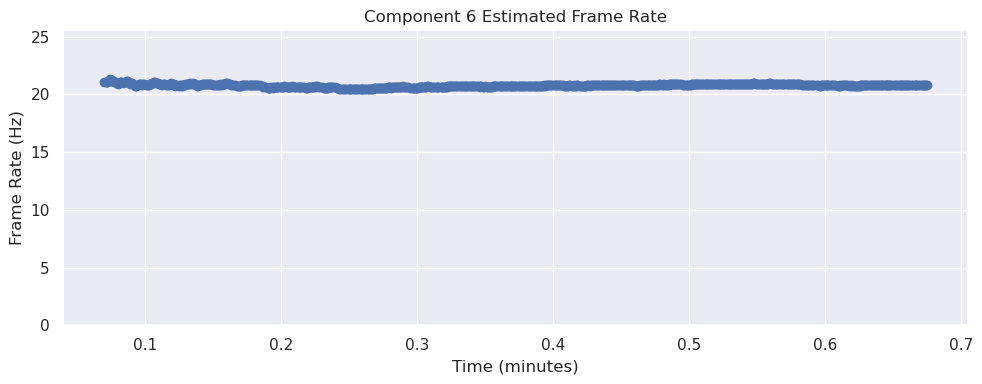

In [58]:
for index, cmpnt_id in enumerate(cmpnt_ids):
#for cmpnt_id in cmpnt_ids:
    print(f"\n🔧 Component {index}:")
    # Filter lines for this component
    comp_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "Measured frame rate" in line]
    # Parse frame rate values and timestamps
    frame_rates = []
    timestamps = []
    for line in comp_lines:
        match = re.search(r"Measured frame rate ([\d.]+)", line)
        if match:
            value = float(match.group(1))
            frame_rates.append(value)
            ts_match = re.match(r"([\d.]+)", line)
            timestamps.append(ts_match.group(1) if ts_match else None)
        else:
            print("No match in frame size line:", line)
    
    # Create a DataFrame
    frame_rate_df0 = pd.DataFrame({
        'timestamp': timestamps,
        'frame_rate': frame_rates
    })
    # Convert microseconds to zero based minutes
    frame_rate_df0['minutes'] = ((frame_rate_df0['timestamp'].astype(float)-min_uS) * u_1)/60  #minutes
    
    #eliminate warm-up
    frame_rate_df = frame_rate_df0[int(len(frame_rate_df0) * 0.1):]

    # Compute statistics
    frame_rate_stats = compute_moments(frame_rate_df['frame_rate'])
    
    # Display statistics
    print(f"Component {index} Statistics (Hz):")
    
    for k, v in frame_rate_stats.items():
        print(f"{k}: {v:.3f}")
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(frame_rate_df['minutes'], frame_rate_df['frame_rate'], marker='o', linestyle='-')
    plt.title(f"Component {index} Estimated Frame Rate")
    plt.xlabel('Time (minutes)')
    plt.ylabel('Frame Rate (Hz)')
    plt.ylim(0, max(frame_rate_df['frame_rate']) * 1.2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [59]:

comp_lines = [line for line in lines if f"cpu_emu {6003}" in line and "Measured frame rate" in line]
print(cmpnt_ids)
print(list(enumerate(cmpnt_ids)))
print(comp_lines[:5])

[6000, 6001, 6002, 6003, 6004, 6005, 6006]
[(0, 6000), (1, 6001), (2, 6002), (3, 6003), (4, 6004), (5, 6005), (6, 6006)]
['1752791687799620 [cpu_emu 6003]:  Measured frame rate 28.4843464 frame Hz. for 1 frames', '1752791687842473 [cpu_emu 6003]:  Measured frame rate 25.6541824 frame Hz. for 2 frames', '1752791687874819 [cpu_emu 6003]:  Measured frame rate 27.1970692 frame Hz. for 3 frames', '1752791687923009 [cpu_emu 6003]:  Measured frame rate 25.2372303 frame Hz. for 4 frames', '1752791687986581 [cpu_emu 6003]:  Measured frame rate 22.5156269 frame Hz. for 6 frames']


In [60]:
print(comp_lines[:5])

['1752791687799620 [cpu_emu 6003]:  Measured frame rate 28.4843464 frame Hz. for 1 frames', '1752791687842473 [cpu_emu 6003]:  Measured frame rate 25.6541824 frame Hz. for 2 frames', '1752791687874819 [cpu_emu 6003]:  Measured frame rate 27.1970692 frame Hz. for 3 frames', '1752791687923009 [cpu_emu 6003]:  Measured frame rate 25.2372303 frame Hz. for 4 frames', '1752791687986581 [cpu_emu 6003]:  Measured frame rate 22.5156269 frame Hz. for 6 frames']



🔧 Component 0:
Component 0, port 6000 Statistics (Hz):
count: 900.000
mean: 14.893
std: 0.021
skew: 0.339
kurtosis: -0.832


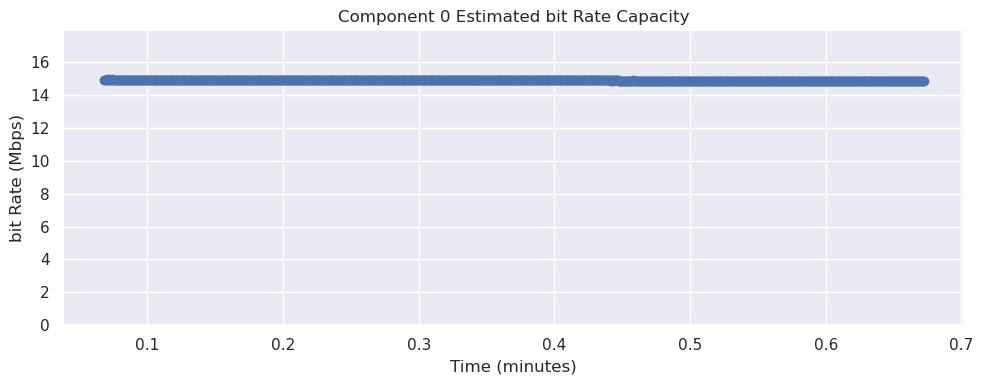


🔧 Component 1:
Component 1, port 6001 Statistics (Hz):
count: 827.000
mean: 13.845
std: 0.066
skew: 1.821
kurtosis: 3.979


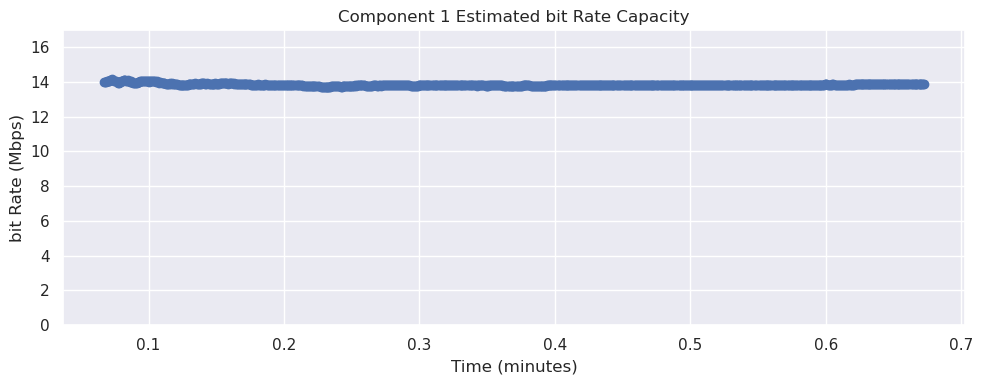


🔧 Component 2:
Component 2, port 6002 Statistics (Hz):
count: 786.000
mean: 13.201
std: 0.052
skew: 1.149
kurtosis: 2.482


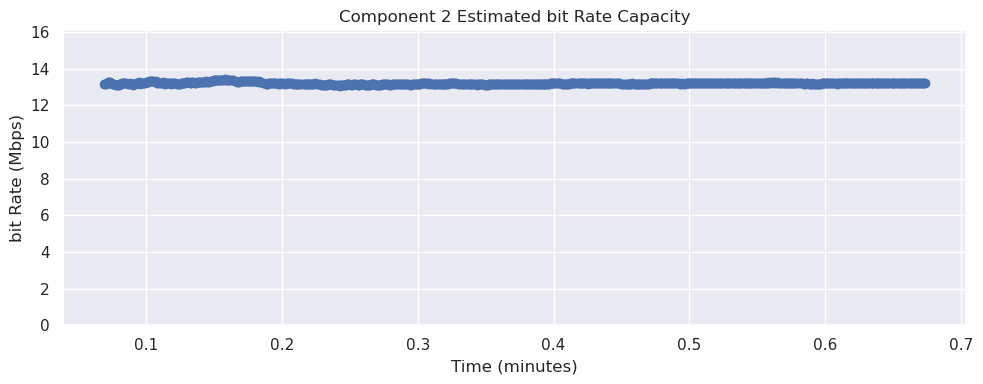


🔧 Component 3:
Component 3, port 6003 Statistics (Hz):
count: 774.000
mean: 13.188
std: 0.131
skew: 1.939
kurtosis: 3.318


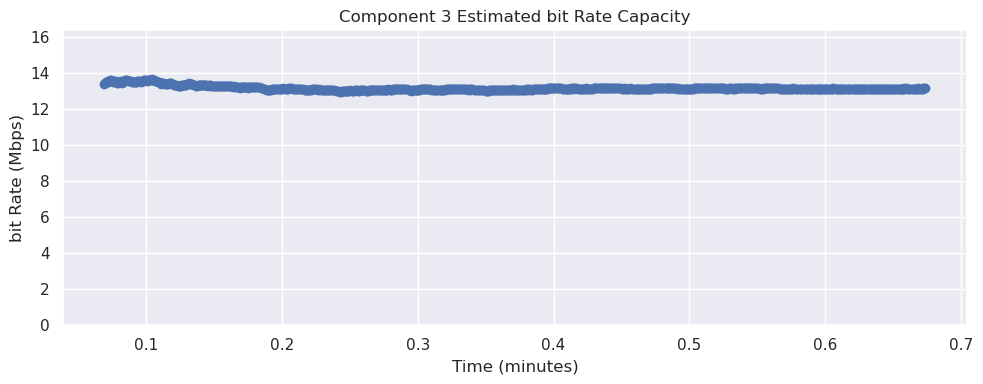


🔧 Component 4:
Component 4, port 6004 Statistics (Hz):
count: 762.000
mean: 12.889
std: 0.125
skew: 1.363
kurtosis: 1.020


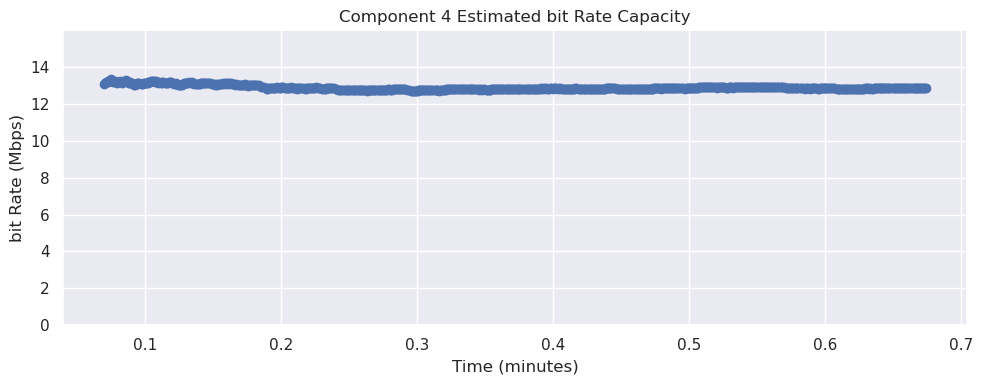


🔧 Component 5:
Component 5, port 6005 Statistics (Hz):
count: 758.000
mean: 12.702
std: 0.109
skew: 0.371
kurtosis: 0.415


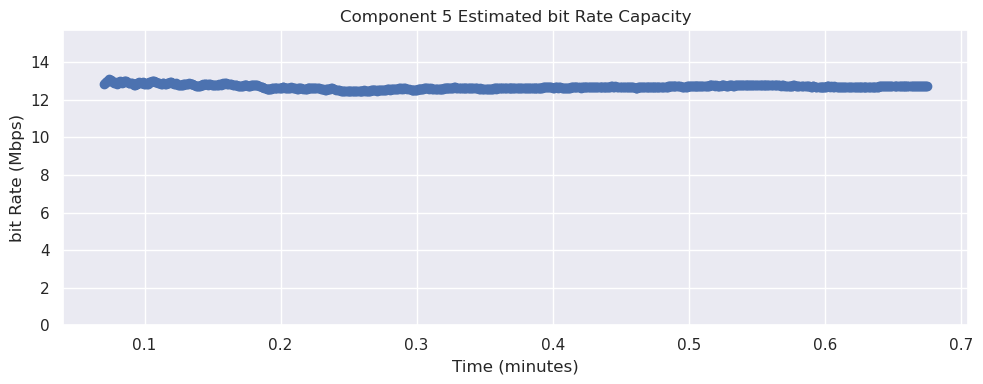


🔧 Component 6:
Component 6, port 6006 Statistics (Hz):
count: 756.000
mean: 12.851
std: 0.068
skew: -0.255
kurtosis: 0.631


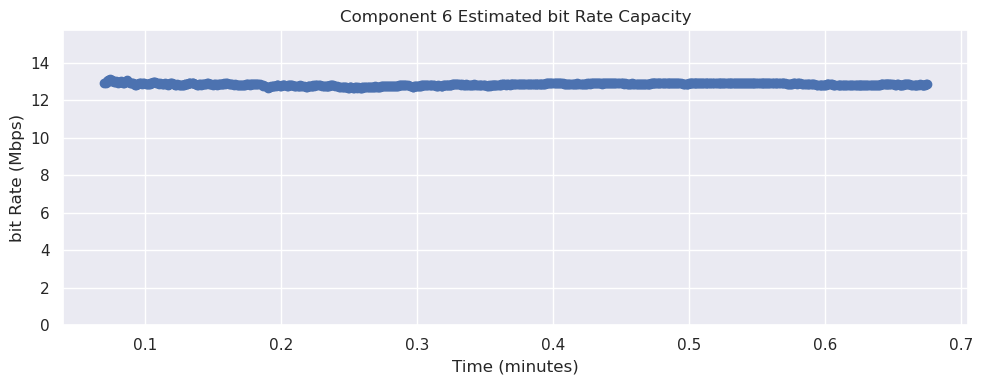

In [61]:
for index, cmpnt_id in enumerate(cmpnt_ids):
#for cmpnt_id in cmpnt_ids:
    print(f"\n🔧 Component {index}:")
    # Filter lines for this component
    comp_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "Measured bit rate" in line]
    # Parse bit rate values and timestamps
    bit_rates = []
    timestamps = []
    for line in comp_lines:
        match = re.search(r"Measured bit rate ([\d.]+)", line)
        if match:
            value = float(match.group(1))*one_M
            bit_rates.append(value)
            ts_match = re.match(r"([\d.]+)", line)
            timestamps.append(ts_match.group(1) if ts_match else None)
        else:
            print("No match in bit line:", line)
    
    # Create a DataFrame
    bit_rate_df0 = pd.DataFrame({
        'timestamp': timestamps,
        'bit_rate': bit_rates
    })

    # Convert microseconds to zero based minutes
    bit_rate_df0['minutes'] = ((bit_rate_df0['timestamp'].astype(float)-min_uS) * u_1)/60  #minutes
       
    #eliminate warm-up
    bit_rate_df = bit_rate_df0[int(len(bit_rate_df0) * 0.1):]

    # Compute statistics
    bit_rate_stats = compute_moments(bit_rate_df['bit_rate'])
    
    # Display statistics
    print(f"Component {index}, port {cmpnt_id} Statistics (Hz):")
    
    for k, v in bit_rate_stats.items():
        print(f"{k}: {v:.3f}")
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(bit_rate_df['minutes'], bit_rate_df['bit_rate'], marker='o', linestyle='-')
    plt.title(f"Component {index} Estimated bit Rate Capacity")
    plt.xlabel('Time (minutes)')
    plt.ylabel('bit Rate (Mbps)')
    plt.ylim(0, max(bit_rate_df['bit_rate']) * 1.2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



🔧 Component 0:
Component 0, port 6000 Statistics (Hz):
count: 999.000
mean: 15.299
std: 2.001
skew: 0.323
kurtosis: -0.143


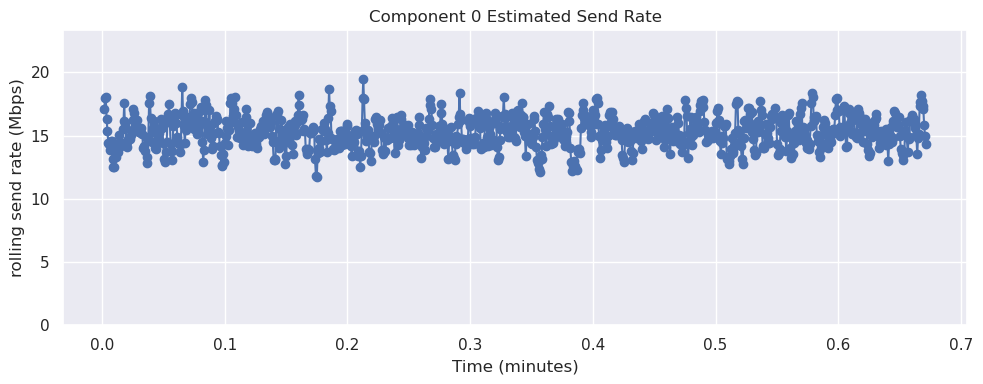


🔧 Component 1:
Component 1, port 6001 Statistics (Hz):
count: 917.000
mean: 14.651
std: 3.215
skew: -0.211
kurtosis: 0.256


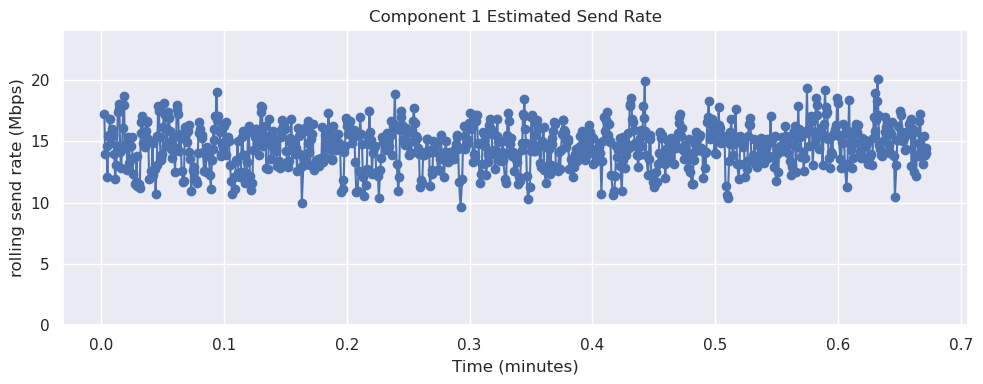


🔧 Component 2:
Component 2, port 6002 Statistics (Hz):
count: 872.000
mean: 14.377
std: 3.738
skew: 0.182
kurtosis: 0.663


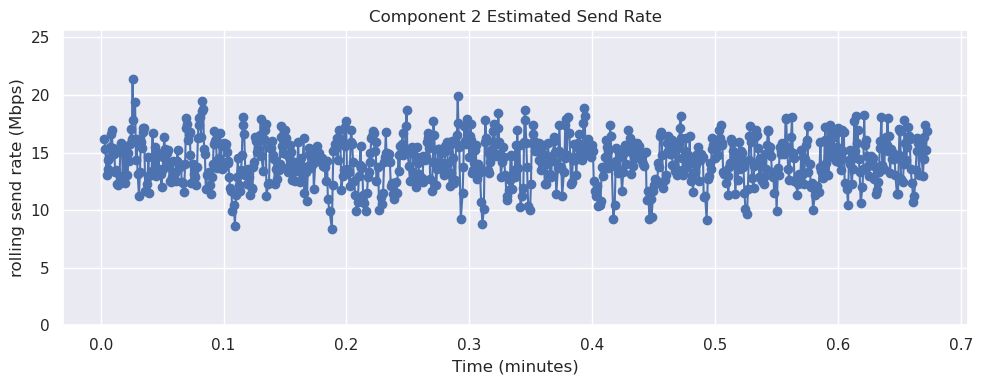


🔧 Component 3:
Component 3, port 6003 Statistics (Hz):
count: 859.000
mean: 14.257
std: 4.024
skew: 0.177
kurtosis: -0.129


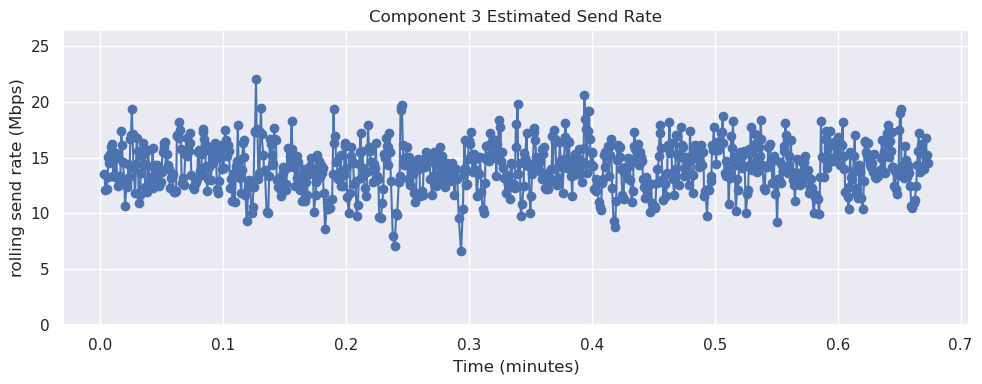


🔧 Component 4:
Component 4, port 6004 Statistics (Hz):
count: 845.000
mean: 14.083
std: 4.174
skew: 0.210
kurtosis: -0.166


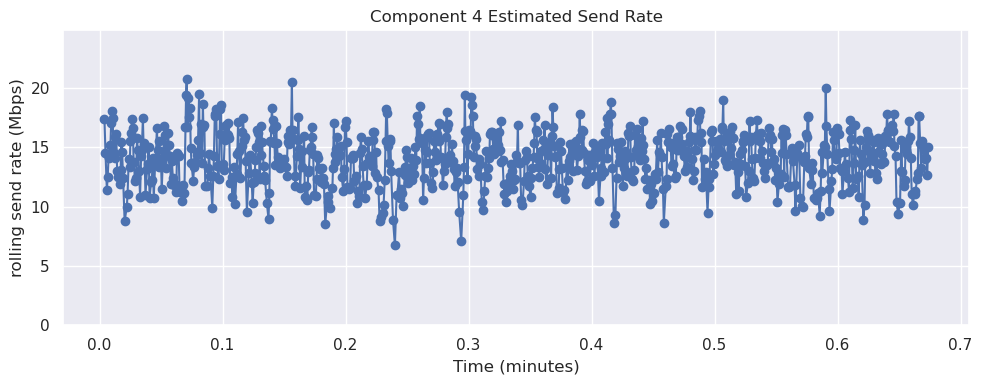


🔧 Component 5:
Component 5, port 6005 Statistics (Hz):
count: 841.000
mean: 14.301
std: 4.385
skew: 0.173
kurtosis: -0.461


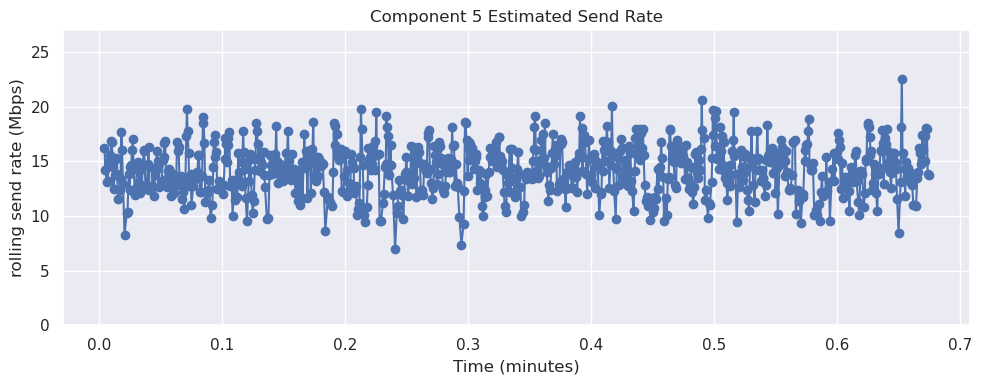


🔧 Component 6:


In [111]:
for index, cmpnt_id in enumerate(cmpnt_ids):
#for cmpnt_id in cmpnt_ids:
    print(f"\n🔧 Component {index}:")
    # Filter lines for this component
    comp_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "Sending frame size" in line]
    if not comp_lines:
        break
    # Parse bit rate values and timestamps
    send_sizes_b = []
    send_times_S = []
    for line in comp_lines:
        match = re.search(r"size = ([\d.]+)", line)
        if match:
            value = B_b*float(match.group(1))*1
            send_sizes_b.append(value)
            ts_match = re.match(r"([\d.]+)", line)
            send_times_S.append(int(ts_match.group(1) if ts_match else None))
        else:
            print("No match in Sending Frame line:", line)
    
    # Create a DataFrame
    sends_df = pd.DataFrame({
        'send_size_b': send_sizes_b,
        'send_time_S': send_times_S
    })

    # Convert microseconds to zero based minutes
    sends_df['minutes'] = ((sends_df['send_time_S'].astype(float)-min_uS) * u_1)/60  #minutes
       
    #eliminate warm-up
    #sends_df = sends_df0[int(len(send_time_df0) * 0.1):]

    # Compute instantaneous bit rate
    sends_df['dt_S'] = sends_df['send_time_S'].diff()
    #sends_df['sz_B'] = sends_df['send_size_b'].diff()
    sends_df['bitrate_bps'] = (sends_df['send_size_b'] * 1) / sends_df['dt_S']
    #send_time_df['bitrate_bps'].fillna(0, inplace=True)
    
    # Rolling bit rate (window size of 3, centered)
    sends_df['bitrate_rolling'] = sends_df['bitrate_bps'].rolling(window=3, center=True).mean()
    
    # Show result
    #print(df[['time', 'bytes', 'bitrate_bps', 'bitrate_rolling']])

    # Compute statistics
    sends_df_stats = compute_moments(sends_df['bitrate_bps'])
    
    #print(comp_lines[0:3])
    #print(sends_df.head(3))
    
    # Display statistics
    print(f"Component {index}, port {cmpnt_id} Statistics (Hz):")
    
    for k, v in sends_df_stats.items():
        print(f"{k}: {v:.3f}")
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(sends_df['minutes'], sends_df['bitrate_rolling']*1, marker='o', linestyle='-')
    plt.title(f"Component {index} Estimated Send Rate")
    plt.xlabel('Time (minutes)')
    plt.ylabel('rolling send rate (Mbps)')
    plt.ylim(0, max(sends_df['bitrate_rolling'].dropna()*1) * 1.2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [109]:
sends_df.head(5)

,send_size_b,send_time_S,minutes,dt_S,bitrate_bps,bitrate_rolling
0,466183.435567,1752791687874355,0.003562,NaN,NaN,NaN
1,539740.645593,1752791687905383,0.004079,31028.0,17.395277,NaN
2,547567.610836,1752791687937013,0.004607,31630.0,17.311654,16.267921
3,672926.427648,1752791687984749,0.005402,47736.0,14.096833,14.172624
4,703879.444324,1752791688048108,0.006458,63359.0,11.109384,13.134185



🔧 Component 0:
Component 0, port 6000 Statistics (Hz):
count: 1000.000
mean: 32.404
std: 3.266
skew: -0.020
kurtosis: -0.145


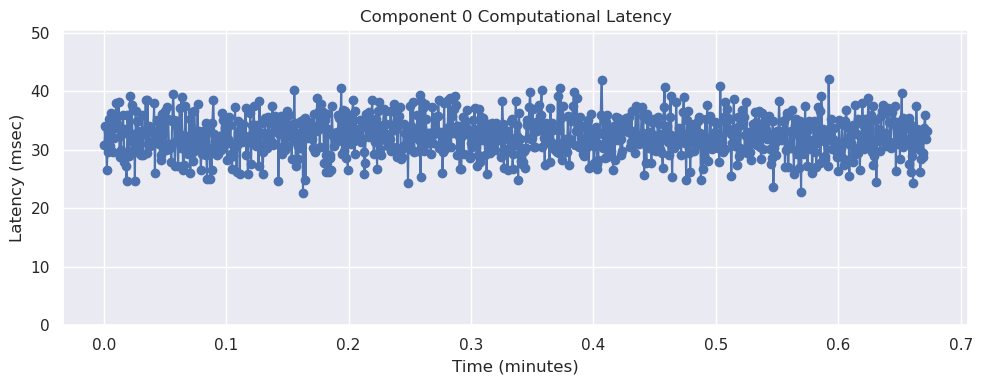


🔧 Component 1:
Component 1, port 6001 Statistics (Hz):
count: 918.000
mean: 32.970
std: 3.264
skew: 0.044
kurtosis: -0.129


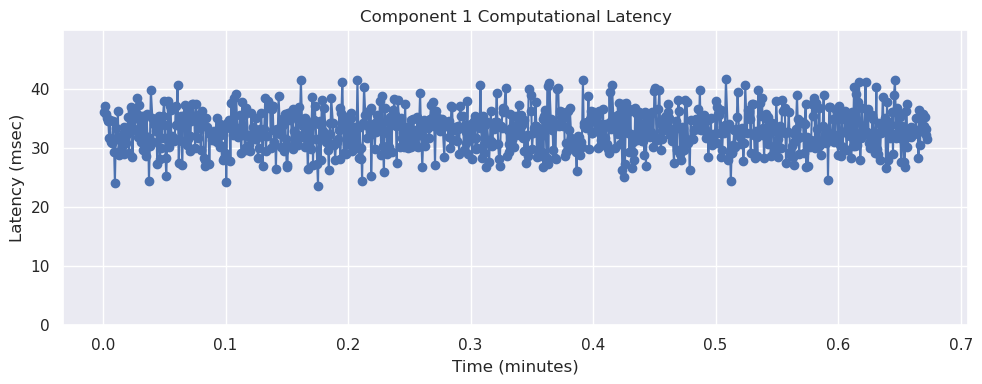


🔧 Component 2:
Component 2, port 6002 Statistics (Hz):
count: 873.000
mean: 32.955
std: 3.273
skew: 0.026
kurtosis: -0.001


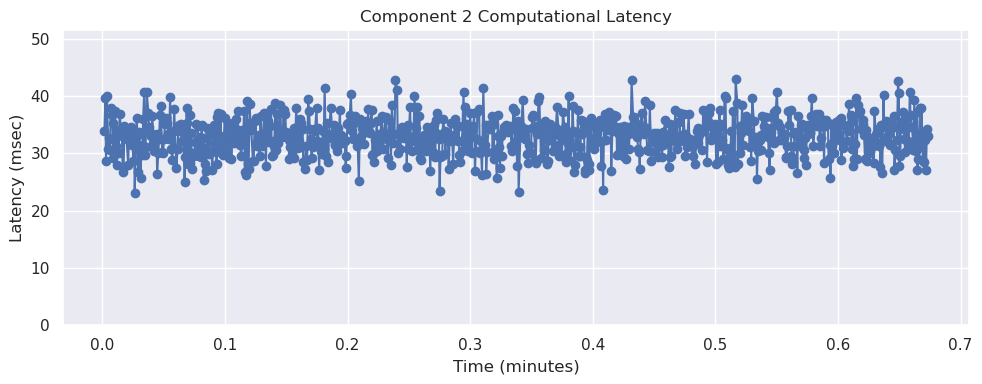


🔧 Component 3:
Component 3, port 6003 Statistics (Hz):
count: 860.000
mean: 31.605
std: 3.083
skew: 0.130
kurtosis: 0.035


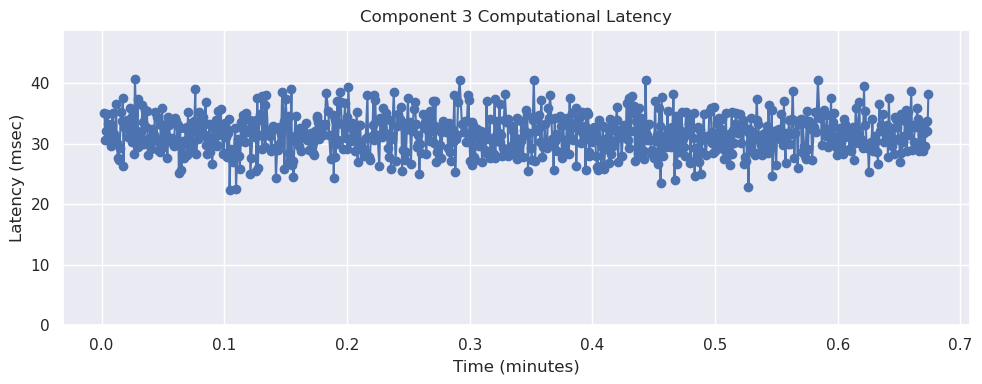


🔧 Component 4:
Component 4, port 6004 Statistics (Hz):
count: 846.000
mean: 31.310
std: 3.033
skew: 0.096
kurtosis: -0.010


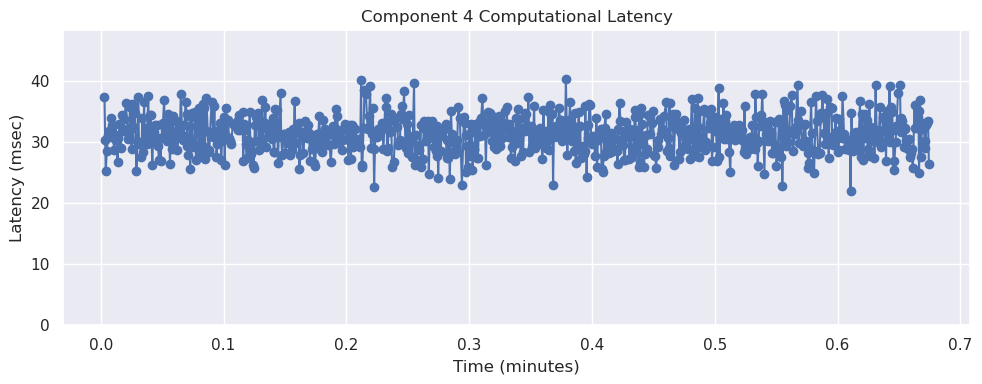


🔧 Component 5:
Component 5, port 6005 Statistics (Hz):
count: 842.000
mean: 31.132
std: 3.066
skew: 0.033
kurtosis: -0.238


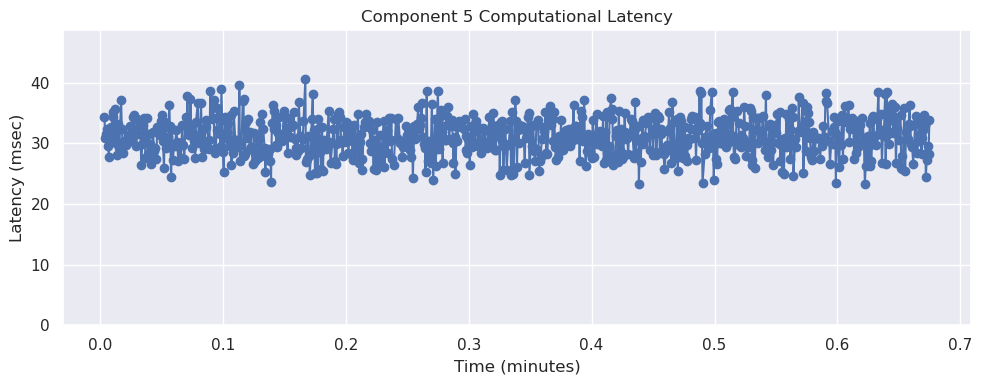


🔧 Component 6:
Component 6, port 6006 Statistics (Hz):
count: 839.000
mean: 31.340
std: 2.944
skew: 0.066
kurtosis: -0.069


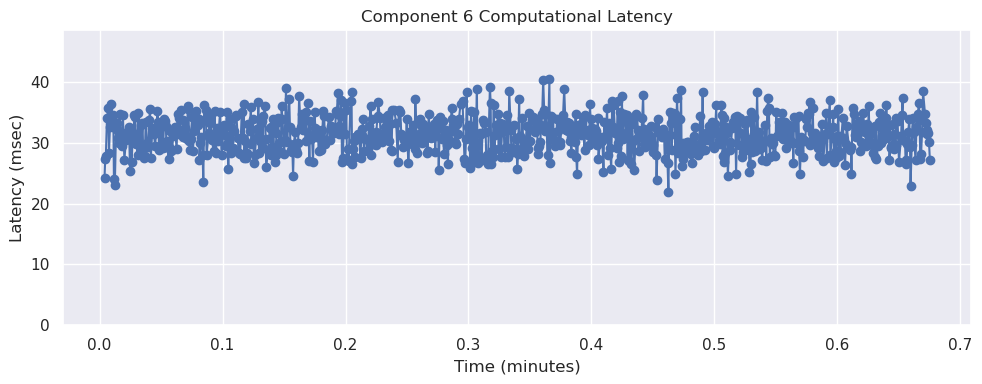

In [62]:
for index, cmpnt_id in enumerate(cmpnt_ids):
#for cmpnt_id in cmpnt_ids:
    print(f"\n🔧 Component {index}:")
    # Filter lines for this component
    comp_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "Measured latencies" in line]
    # Parse bit rate values and timestamps
    y = []
    x = []
    for line in comp_lines:
        match = re.search(r"last_cmp_lat_uS = ([\d.]+)", line)
        if match:
            value = int(match.group(1))
            y.append(value*u_m)
            ts_match = re.match(r"([\d.]+)", line)
            x.append(ts_match.group(1) if ts_match else None)
        else:
            print("No match in latency line:", line)
    
    # Create a DataFrame
    latency = pd.DataFrame({
        'timestamp': x,
        'latency': y
    })

    # Convert microseconds to zero based minutes
    latency['minutes'] = ((latency['timestamp'].astype(float)-min_uS) * u_1)/60  #minutes
    
    # Compute statistics
    latency_stats = compute_moments(latency['latency'])
    
    # Display statistics
    print(f"Component {index}, port {cmpnt_id} Statistics (Hz):")
    
    for k, v in latency_stats.items():
        print(f"{k}: {v:.3f}")
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(latency['minutes'], latency['latency'], marker='o', linestyle='-')
    plt.title(f"Component {index} Computational Latency")
    plt.xlabel('Time (minutes)')
    plt.ylabel('Latency (msec)')
    plt.ylim(0, max(latency['latency']) * 1.2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



🔧 Component 0:
Component 6000, port 6000 Statistics (usec):
count: 999.000
mean: 7.924
std: 0.809
skew: -0.038
kurtosis: -0.137
Number of drops is: 0
drop % is: 0.0


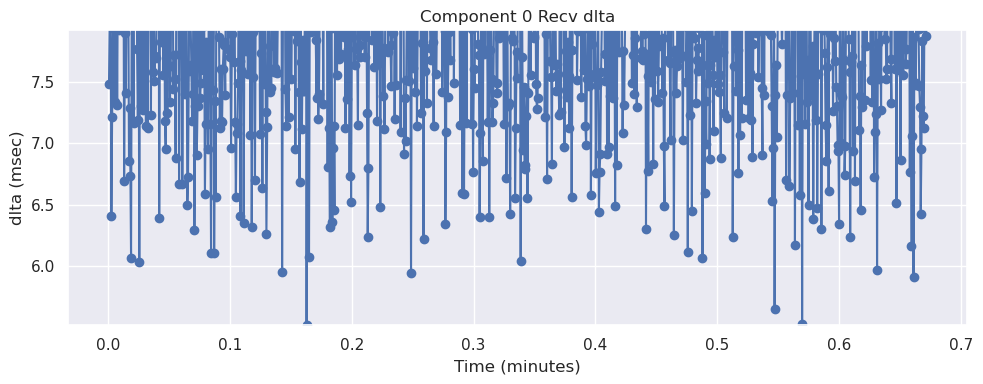


🔧 Component 1:
Component 6001, port 6001 Statistics (usec):
count: 999.000
mean: 9.873
std: 9.948
skew: 1.787
kurtosis: 3.313
Number of drops is: 82
drop % is: 8.2


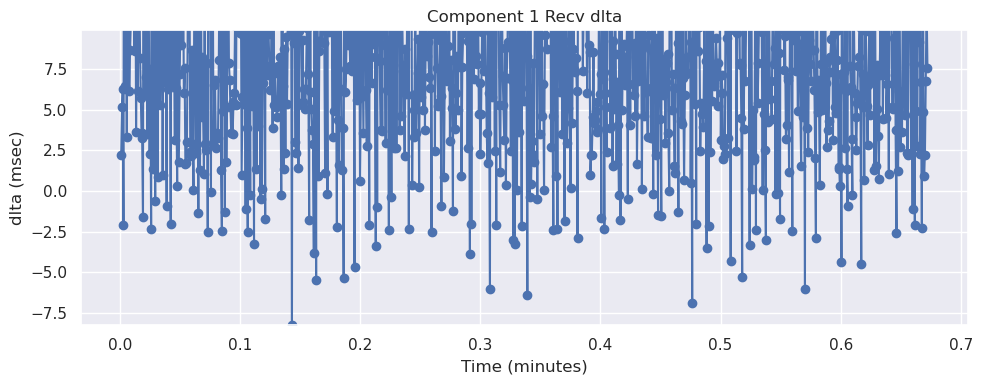


🔧 Component 2:
Component 6002, port 6002 Statistics (usec):
count: 917.000
mean: 12.514
std: 12.616
skew: 1.761
kurtosis: 2.813
Number of drops is: 45
drop % is: 4.9


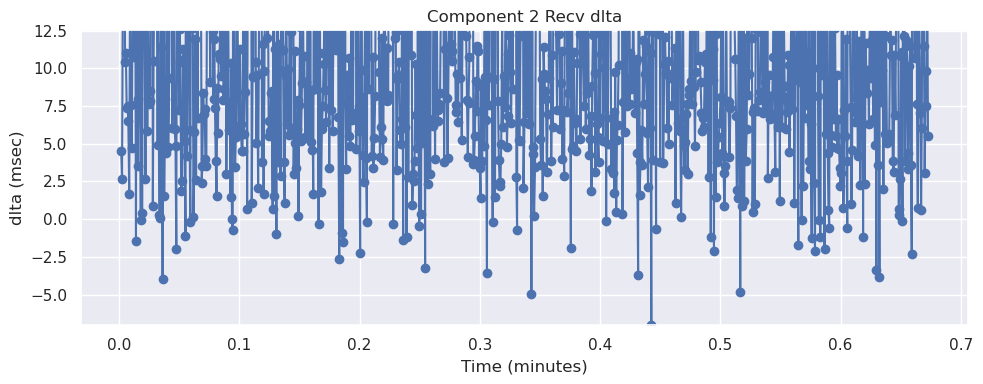


🔧 Component 3:
Component 6003, port 6003 Statistics (usec):
count: 872.000
mean: 15.064
std: 13.740
skew: 1.827
kurtosis: 2.947
Number of drops is: 13
drop % is: 1.5


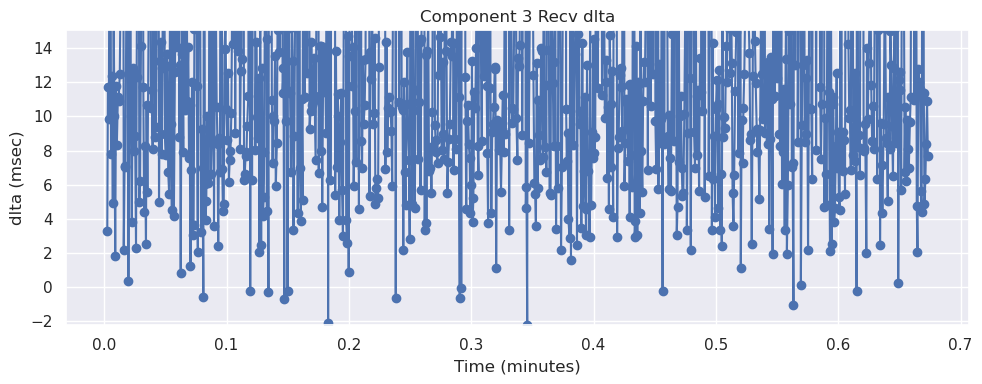


🔧 Component 4:
Component 6004, port 6004 Statistics (usec):
count: 859.000
mean: 16.066
std: 14.577
skew: 1.764
kurtosis: 2.740
Number of drops is: 14
drop % is: 1.6


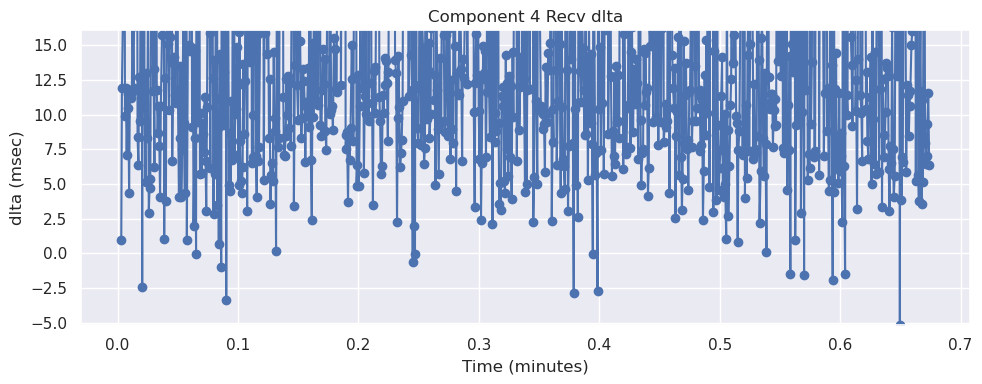


🔧 Component 5:
Component 6005, port 6005 Statistics (usec):
count: 845.000
mean: 16.686
std: 15.074
skew: 1.750
kurtosis: 2.590
Number of drops is: 4
drop % is: 0.5


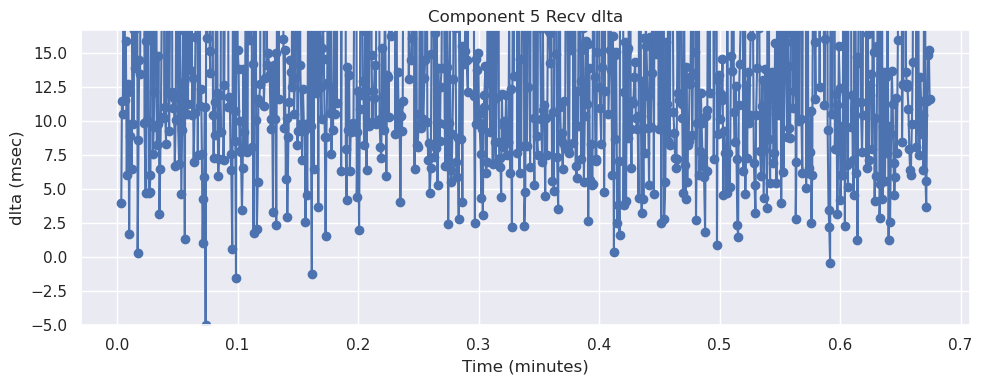


🔧 Component 6:
Component 6006, port 6006 Statistics (usec):
count: 841.000
mean: 16.669
std: 14.965
skew: 1.744
kurtosis: 2.561
Number of drops is: 3
drop % is: 0.4


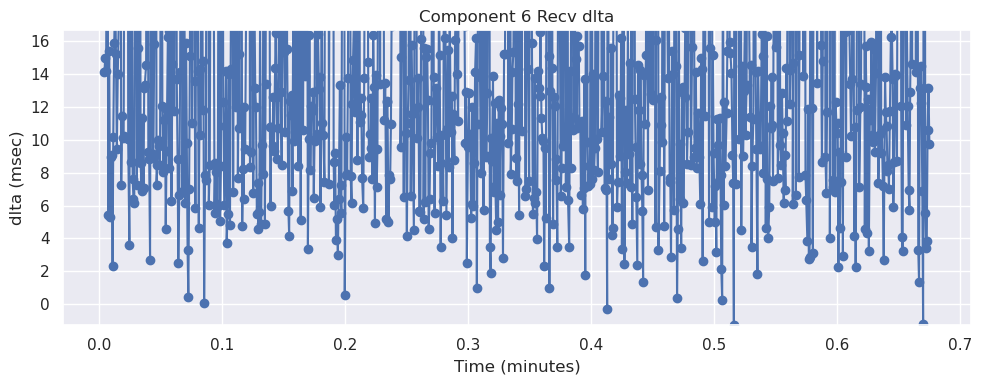

In [63]:
for index, cmpnt_id in enumerate(cmpnt_ids):
#for cmpnt_id in cmpnt_ids:
    print(f"\n🔧 Component {index}:")
    # Filter lines for this component
    comp_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "comparing" in line]
    # Parse bit rate values and timestamps
    y  = []
    x  = []
    for line in comp_lines:
        match = re.search(r"last_rdy_uS ([\d.]+)", line)
        if match:
            value = float(match.group(1))
            ts_match = re.match(r"([\d.]+)", line)
            x.append(ts_match.group(1) if ts_match else None)
        else:
            print("No match in last_rdy_uS line:", line)
        match = re.search(r"parsed.timestamp_uS ([\d.]+)", line)
        if match:
            value1 = float(match.group(1))
            y.append((value1-value)*u_m) #u_m
        else:
            print("No match in parsed.timestamp_uS line:", line)
    
    # Create a DataFrame
    drops = pd.DataFrame({
        'timestamp': x,
        'dlta': y
    })
    #First record is useless for this report
    drops.drop(index=drops.index[0], inplace=True)
    
    # Convert microseconds to zero based minutes
    drops['minutes'] = ((drops['timestamp'].astype(float)-min_uS) * u_1)/60  #minutes
    
    # Compute statistics
    drops_stats = compute_moments(drops['dlta'])
    
    # Display statistics
    print(f"Component {cmpnt_id}, port {cmpnt_id} Statistics (usec):")
    
    for k, v in drops_stats.items():
        print(f"{k}: {v:.3f}")
        
    neg_count = sum(1 for d in y if d < 0)
    print(f"Number of drops is: {neg_count}")
    print(f"drop % is: {100*neg_count/len(y):.1f}")
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(drops['minutes'], drops['dlta'], marker='o', linestyle='-')
    plt.title(f"Component {index} Recv dlta")
    plt.xlabel('Time (minutes)')
    plt.ylabel('dlta (msec)')
    plt.ylim(min(drops['dlta']), (drops['dlta'].mean()))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [64]:
for index, cmpnt_id in enumerate(cmpnt_ids):
#for cmpnt_id in cmpnt_ids:
    print(f"\n🔧 Component {index}:")
    # Filter lines for this component
    comp_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "comparing" in line]
    # Parse bit rate values and timestamps
    y  = []
    x  = []
    for line in comp_lines:
        match = re.search(r"last_rdy_uS ([\d.]+)", line)
        if match:
            value = float(match.group(1))
            ts_match = re.match(r"([\d.]+)", line)
            x.append(ts_match.group(1) if ts_match else None)
        else:
            print("No match in last_rdy_uS line:", line)
        match = re.search(r"parsed.timestamp_uS ([\d.]+)", line)
        if match:
            value1 = float(match.group(1))
            y.append((value1-value)*u_m) #u_m
        else:
            print("No match in parsed.timestamp_uS line:", line)
    
    # Create a DataFrame
    drops = pd.DataFrame({
        'timestamp': x,
        'dlta': y
    })
    #First record is useless for this report
    drops.drop(index=drops.index[0], inplace=True)
    
    # Convert microseconds to zero based minutes
    drops['minutes'] = ((drops['timestamp'].astype(float)-min_uS) * u_1)/60  #minutes
    
    # Compute statistics
    drops_stats = compute_moments(drops['dlta'])
    
    # Display statistics
    print(f"Component {cmpnt_id}, port {cmpnt_id} Statistics (usec):")
    
    for k, v in drops_stats.items():
        print(f"{k}: {v:.3f}")
        
    neg_count = sum(1 for d in y if d < 0)
    print(f"Number of drops is: {neg_count}")
    print(f"drop % is: {100*neg_count/len(y):.1f}")
    


🔧 Component 0:
Component 6000, port 6000 Statistics (usec):
count: 999.000
mean: 7.924
std: 0.809
skew: -0.038
kurtosis: -0.137
Number of drops is: 0
drop % is: 0.0

🔧 Component 1:
Component 6001, port 6001 Statistics (usec):
count: 999.000
mean: 9.873
std: 9.948
skew: 1.787
kurtosis: 3.313
Number of drops is: 82
drop % is: 8.2

🔧 Component 2:
Component 6002, port 6002 Statistics (usec):
count: 917.000
mean: 12.514
std: 12.616
skew: 1.761
kurtosis: 2.813
Number of drops is: 45
drop % is: 4.9

🔧 Component 3:
Component 6003, port 6003 Statistics (usec):
count: 872.000
mean: 15.064
std: 13.740
skew: 1.827
kurtosis: 2.947
Number of drops is: 13
drop % is: 1.5

🔧 Component 4:
Component 6004, port 6004 Statistics (usec):
count: 859.000
mean: 16.066
std: 14.577
skew: 1.764
kurtosis: 2.740
Number of drops is: 14
drop % is: 1.6

🔧 Component 5:
Component 6005, port 6005 Statistics (usec):
count: 845.000
mean: 16.686
std: 15.074
skew: 1.750
kurtosis: 2.590
Number of drops is: 4
drop % is: 0.5

🔧

In [65]:
drops.head(5)

,timestamp,dlta,minutes
1,1752791687905723,14.147,0.004085
2,1752791687937305,14.954,0.004611
3,1752791687985230,14.188,0.005410
4,1752791688048643,35.603,0.006467
5,1752791688087700,5.403,0.007118


In [66]:
#max(latency['latency'])
comp_lines[0:5]

['1752791687875149 [cpu_emu 6006]: comparing last_rdy_uS 6 to parsed.timestamp_uS 1752791687660620 frame 1',
 '1752791687905723 [cpu_emu 6006]: comparing last_rdy_uS 1752791687684832 to parsed.timestamp_uS 1752791687698979 frame 2',
 '1752791687937305 [cpu_emu 6006]: comparing last_rdy_uS 1752791687726328 to parsed.timestamp_uS 1752791687741282 frame 3',
 '1752791687985230 [cpu_emu 6006]: comparing last_rdy_uS 1752791687769144 to parsed.timestamp_uS 1752791687783332 frame 4',
 '1752791688048643 [cpu_emu 6006]: comparing last_rdy_uS 1752791687817435 to parsed.timestamp_uS 1752791687853038 frame 6']

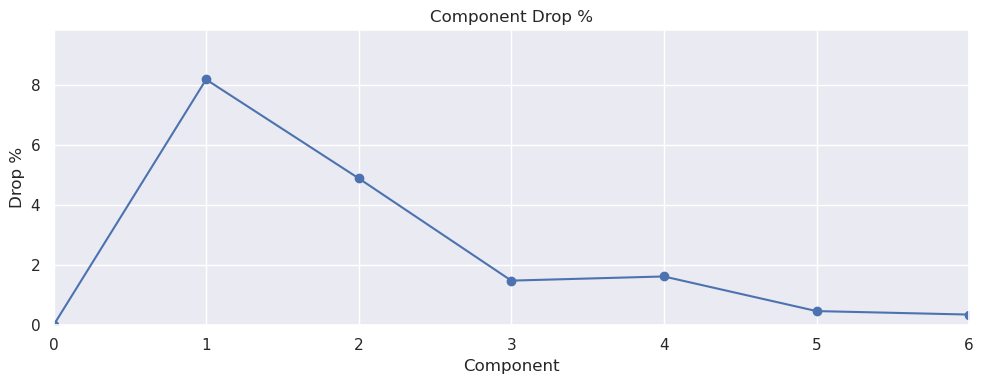

In [67]:
y = []
x = []
for index, cmpnt_id in enumerate(cmpnt_ids):
#for cmpnt_id in cmpnt_ids:
    # Filter lines for this component
    drop_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "drop" in line]
    recd_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "recd" in line]
    #print("Frames Recvd:",len(recd_lines))
    #print("Frames Dropped:",len(drop_lines))
    d = len(drop_lines)
    r = len(recd_lines)
    #print("Drop frames fraction: ", d/r)
    x.append(int(index))
    y.append(100*d/r)
#    print(f"drop % is: {100*neg_count/len(y):.1f}")
    
# Create a DataFrame
drops0 = pd.DataFrame({
    'component': x,
    'fraction': y
})

drops = drops0.sort_values(by='component', ascending=False)
    
# Plot
plt.figure(figsize=(10, 4))
plt.plot(drops['component'], drops['fraction'], marker='o', linestyle='-')
plt.title(f"Component Drop %")
plt.xlabel('Component')
plt.ylabel('Drop %')
plt.ylim(0, max(drops['fraction']) * 1.2)
plt.xlim(int(min(drops['component'])), int(max(drops['component'])))
plt.grid(True)
plt.tight_layout()
plt.show()

In [68]:
drops0

,component,fraction
0,0,0.000000
1,1,8.200000
2,2,4.901961
3,3,1.489118
4,4,1.627907
5,5,0.472813
6,6,0.356295


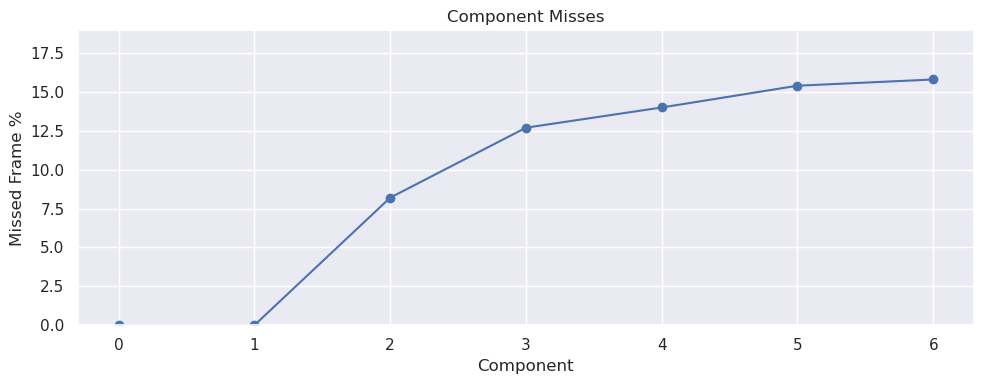

In [69]:
y = []
x = []
for index, cmpnt_id in enumerate(cmpnt_ids):
    # Filter lines for this component
    missed_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "Missed frame ratio" in line]
    # Get the last match, if any
    if missed_lines:
        last_match = missed_lines[-1]
        #print("Last matching line:")
        #print(last_match)
    else:
        print(f"No matches found for '{search_string}'")

    match = re.search(r"Missed frame ratio: ([\d.]+)", last_match)
    if match:
        value = float(match.group(1))
        #print(value)
        y.append(value*100)
        x.append(index)
    else:
        print("No match in Missed line:", last_match)
        y.append(0)
        x.append(cmpnt_id)
    
# Create a DataFrame
    misses0 = pd.DataFrame({
        'component': x,
        'fraction': y
    })

misses = misses0.sort_values(by='component', ascending=False)
    
# Plot
plt.figure(figsize=(10, 4))
plt.plot(misses['component'], misses['fraction'], marker='o', linestyle='-')
plt.title(f"Component Misses")
plt.xlabel('Component')
plt.ylabel('Missed Frame %')
plt.ylim(0, max(misses['fraction']) * 1.2)
plt.grid(True)
plt.tight_layout()
plt.show()

# Define the search term and file path
#search_string = "drop"
#file_path = "log.txt"  # replace with your file path

# Read and filter lines
#with open(file_path, 'r') as f:
#    matches = [line.strip() for line in f if search_string in line]

# Get the last match, if any
#if matches:
#    last_match = matches[-1]
#    print("Last matching line:")
#    print(last_match)
#else:
#    print(f"No matches found for '{search_string}'")


In [70]:
#missed_lines

In [71]:
#drops['fraction'].sum()

In [72]:
misses

,component,fraction
6,6,15.8
5,5,15.4
4,4,14.0
3,3,12.7
2,2,8.2
1,1,0.0
0,0,0.0


In [73]:
#misses['fraction']-drops['fraction']


🔧 Component 6000:


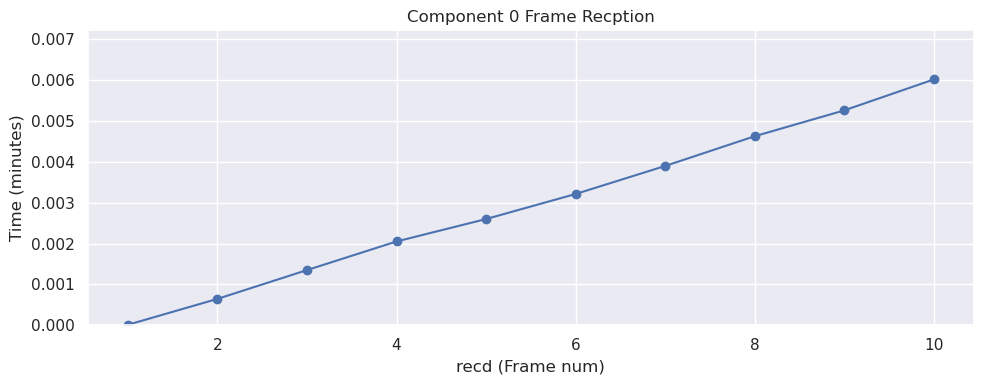


🔧 Component 6001:


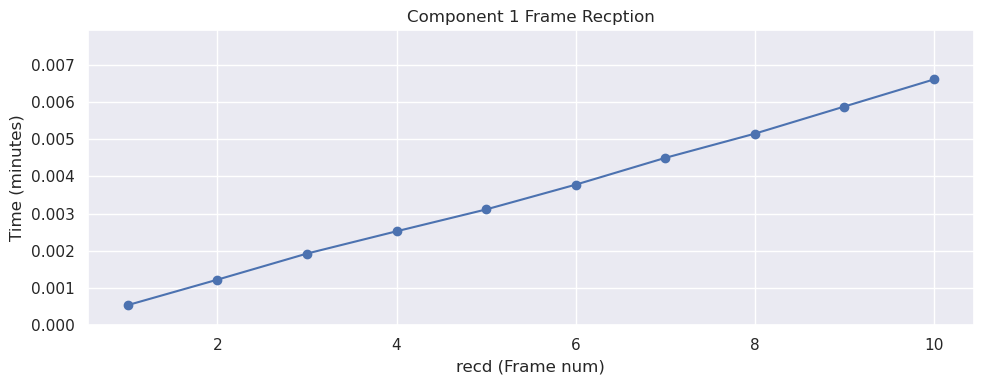


🔧 Component 6002:


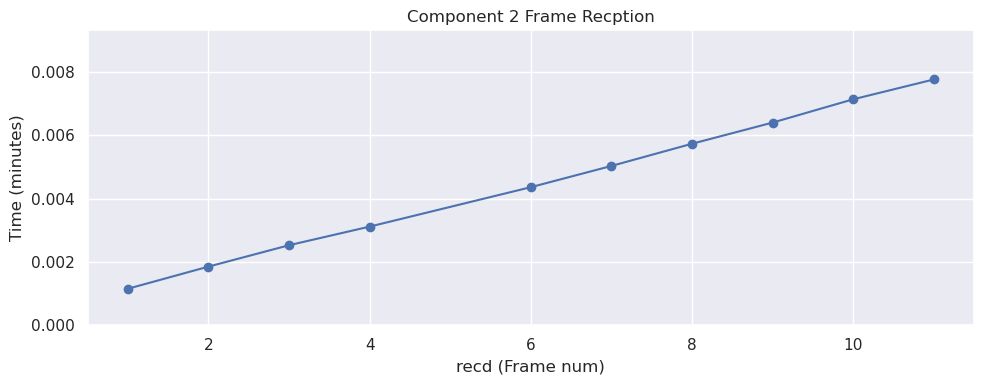


🔧 Component 6003:


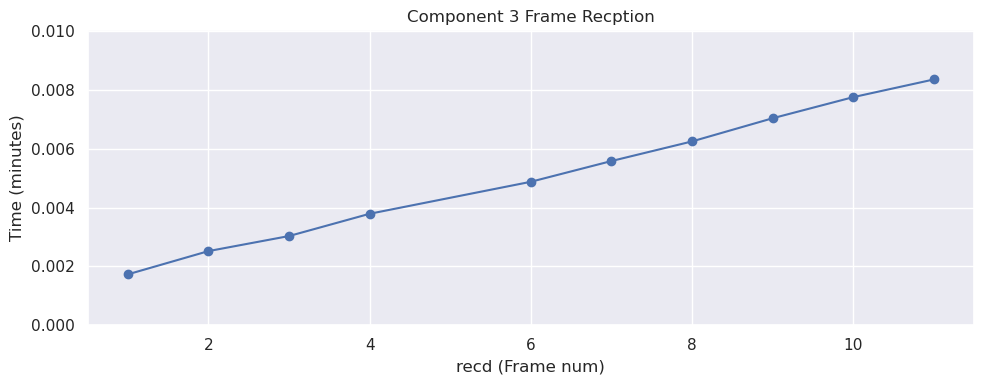


🔧 Component 6004:


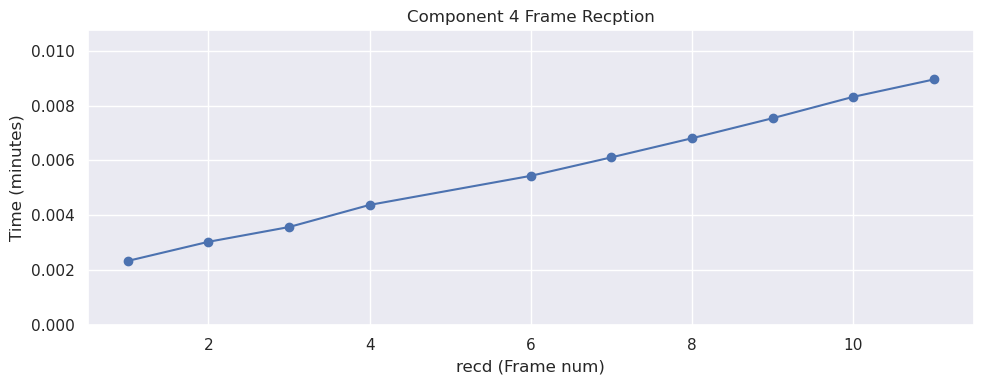


🔧 Component 6005:


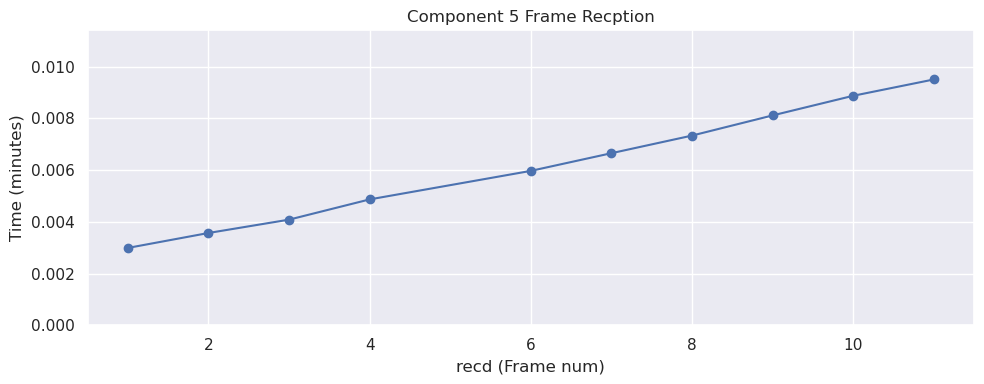


🔧 Component 6006:


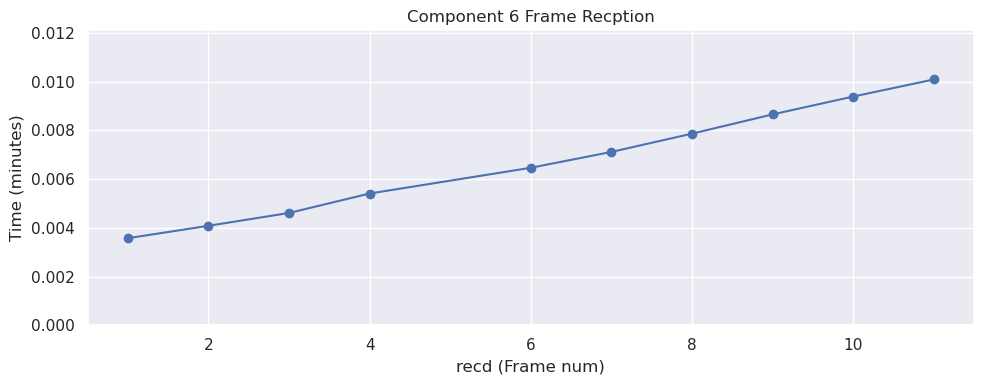

In [74]:
for index, cmpnt_id in enumerate(cmpnt_ids):
    y = []
    x = []
    print(f"\n🔧 Component {cmpnt_id}:")
    # Filter lines for this component
    recd_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "recd" in line]
    # Parse bit rate values and timestamps
    for line in recd_lines:
        match = re.search(r"recd ([\d.]+)", line)
        if match:
            value = float(match.group(1))
            y.append(value)
            ts_match = re.match(r"([\d.]+)", line)
            x.append(ts_match.group(1) if ts_match else None)
        else:
            print("No match in recd line:", line)
    
    # Create a DataFrame
    #print("len(lines)=",len(lines))
    #print("len(comp_lines)=",len(comp_lines))
    #print("len(x)=",len(x))
    recd = pd.DataFrame({
        'timestamp': x,
        'frame': y
    })

    # Convert microseconds to zero based minutes
    recd['minutes'] = ((recd['timestamp'].astype(float)-min_uS) * u_1)/60  #minutes
    
    # Compute statistics
    recd_stats = compute_moments(recd['frame'])
    
    # Display statistics
    #print(f"Component {component_id} Statistics (Hz):")
    
    #for k, v in recd_stats.items():
        #print(f"{k}: {v:.3f}")
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(recd['frame'].head(10), recd['minutes'].head(10), marker='o', linestyle='-')
    plt.title(f"Component {index} Frame Recption")
    plt.ylabel('Time (minutes)')
    plt.xlabel('recd (Frame num)')
    plt.ylim(0, max(recd['minutes'].head(10)) * 1.2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [75]:
recd_lines[:5]

['1752791687875145 [cpu_emu 6006]:  recd 1',
 '1752791687905719 [cpu_emu 6006]:  recd 2',
 '1752791687937301 [cpu_emu 6006]:  recd 3',
 '1752791687985226 [cpu_emu 6006]:  recd 4',
 '1752791688048639 [cpu_emu 6006]:  recd 6']

/scratch/slurm/50909073/.cache/tmp/ipykernel_253588/802805292.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


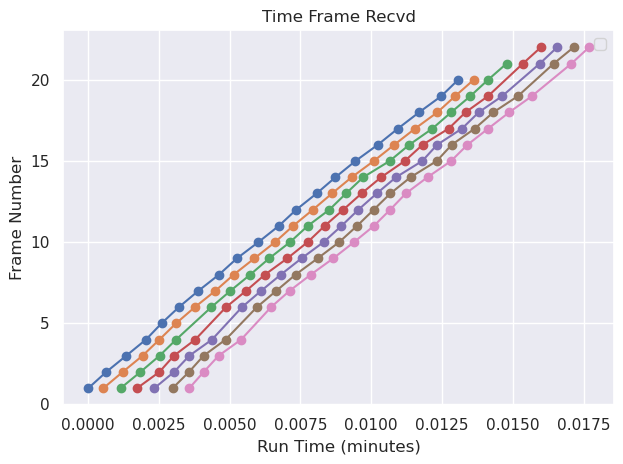

In [76]:
for cmpnt_id in cmpnt_ids:
    y = []
    x = []
    # Filter lines for this component
    recd_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "recd" in line]
    # Parse bit rate values and timestamps
    for line in recd_lines:
        match = re.search(r"recd ([\d.]+)", line)
        if match:
            value = float(match.group(1))
            y.append(value)
            ts_match = re.match(r"([\d.]+)", line)
            x.append(ts_match.group(1) if ts_match else None)
        else:
            print("No match in recd line:", line)
    
    # Create a DataFrame
    recd = pd.DataFrame({
        'timestamp': x,
        'frame': y
    })

    # Convert microseconds to zero based minutes
    recd['minutes'] = ((recd['timestamp'].astype(float)-min_uS) * u_1)/60  #minutes
    
    # Compute statistics
    #recd_stats = compute_moments(recd['frame'])
    
    # Display statistics
    #print(f"Component {component_id} Statistics (Hz):")
    
    #for k, v in recd_stats.items():
        #print(f"{k}: {v:.3f}")
    
    # Plot
    plt.plot(recd['minutes'].head(20), recd['frame'].head(20), marker='o', linestyle='-')
    
# Add labels and legend
plt.xlabel('Run Time (minutes)')
plt.ylabel('Frame Number')
plt.title('Time Frame Recvd')
plt.legend()

# Show grid and plot
plt.grid(True)
plt.tight_layout()
plt.show()


/scratch/slurm/50909073/.cache/tmp/ipykernel_253588/919471509.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


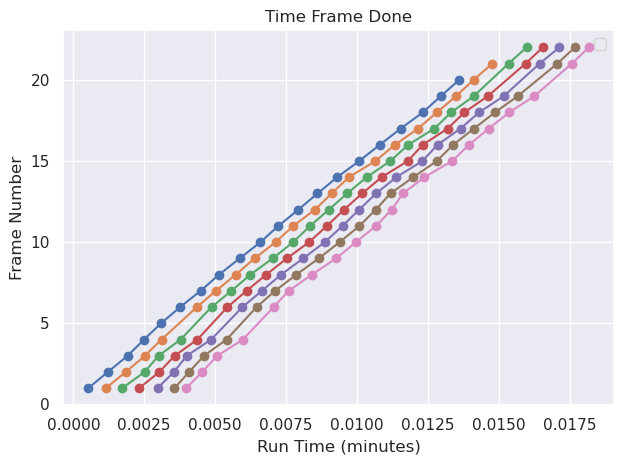

In [77]:
for cmpnt_id in cmpnt_ids:
    y = []
    x = []
    # Filter lines for this component
    done_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "done" in line]
    # Parse bit rate values and timestamps
    for line in done_lines:
        match = re.search(r"done (\([\d.]+\))", line)
        if match:
            #print(match.group(1))
            #print(match.group(1).strip("()"))
            value = float(match.group(1).strip("()"))
            #print(value)
            y.append(value)
            ts_match = re.match(r"([\d.]+)", line)
            x.append(ts_match.group(1) if ts_match else None)
        else:
            print("No match in done line:", line)
    
    # Create a DataFrame
    done = pd.DataFrame({
        'timestamp': x,
        'frame': y
    })

    # Convert microseconds to zero based minutes
    done['minutes'] = ((done['timestamp'].astype(float)-min_uS) * u_1)/60  #minutes
    
    # Compute statistics
    #recd_stats = compute_moments(recd['frame'])
    
    # Display statistics
    #print(f"Component {component_id} Statistics (Hz):")
    
    #for k, v in recd_stats.items():
        #print(f"{k}: {v:.3f}")
    
    # Plot
    plt.plot(done['minutes'].head(20), done['frame'].head(20), marker='o', linestyle='-')
    
# Add labels and legend
plt.xlabel('Run Time (minutes)')
plt.ylabel('Frame Number')
plt.title('Time Frame Done')
plt.legend()

# Show grid and plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [78]:
done_lines[0:5]

['1752791687899357 [cpu_emu 6006]:  done (1)',
 '1752791687933067 [cpu_emu 6006]:  done (2)',
 '1752791687965162 [cpu_emu 6006]:  done (3)',
 '1752791688019327 [cpu_emu 6006]:  done (4)',
 '1752791688084319 [cpu_emu 6006]:  done (6)']

In [79]:
#import matplotlib.pyplot as plt

# Example data
#x = [0, 1, 2, 3, 4]
#y1 = [0, 1, 4, 9, 16]
#y2 = [0, 1, 2, 3, 4]
#y3 = [16, 9, 4, 1, 0]

# Plot each series with a label
#plt.plot(x, y1, label='y = x^2', color='blue')
#plt.plot(x, y2, label='y = x', color='green')
#plt.plot(x, y3, label='y = -x^2', color='red')

# Add labels and legend
#plt.xlabel('X-axis')
#plt.ylabel('Y-axis')
#plt.title('Multiple Series on One Plot')
#plt.legend()

# Show grid and plot
#plt.grid(True)
#plt.tight_layout()
#plt.show()


In [80]:
#done.head(20)

In [81]:
for index, item in enumerate(cmpnt_ids):
    print(f"{index}: {item}")


0: 6000
1: 6001
2: 6002
3: 6003
4: 6004
5: 6005
6: 6006
